# **Sales Prediction**



In [58]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split,cross_val_score,GridSearchCV
from sklearn.preprocessing import StandardScaler,OneHotEncoder,OrdinalEncoder,PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics import r2_score, mean_squared_error,mean_absolute_error
from sklearn.ensemble import RandomForestRegressor,ExtraTreesRegressor
from sklearn.linear_model import LinearRegression,Ridge
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor
import xgboost as xgb

from pathlib import Path
import pickle

import warnings

# Define custom color palette
palette = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#96CEB4', '#FFEEAD']

In [59]:
df = pd.read_csv('train_v9rqX0R.csv')
df.head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,FDA15,9.30,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380
1,DRC01,5.92,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228
2,FDN15,17.50,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700
3,FDX07,19.20,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,NaN,Tier 3,Grocery Store,732.3800
4,NCD19,8.93,Low Fat,0.000000,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052


In [60]:
df.shape

(8523, 12)

In [61]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8523 entries, 0 to 8522
Data columns (total 12 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Item_Identifier            8523 non-null   object 
 1   Item_Weight                7060 non-null   float64
 2   Item_Fat_Content           8523 non-null   object 
 3   Item_Visibility            8523 non-null   float64
 4   Item_Type                  8523 non-null   object 
 5   Item_MRP                   8523 non-null   float64
 6   Outlet_Identifier          8523 non-null   object 
 7   Outlet_Establishment_Year  8523 non-null   int64  
 8   Outlet_Size                6113 non-null   object 
 9   Outlet_Location_Type       8523 non-null   object 
 10  Outlet_Type                8523 non-null   object 
 11  Item_Outlet_Sales          8523 non-null   float64
dtypes: float64(4), int64(1), object(7)
memory usage: 799.2+ KB


In [62]:
df.describe()

,Item_Weight,Item_Visibility,Item_MRP,Outlet_Establishment_Year,Item_Outlet_Sales
count,7060.000000,8523.000000,8523.000000,8523.000000,8523.000000
mean,12.857645,0.066132,140.992782,1997.831867,2181.288914
std,4.643456,0.051598,62.275067,8.371760,1706.499616
min,4.555000,0.000000,31.290000,1985.000000,33.290000
25%,8.773750,0.026989,93.826500,1987.000000,834.247400
50%,12.600000,0.053931,143.012800,1999.000000,1794.331000
75%,16.850000,0.094585,185.643700,2004.000000,3101.296400
max,21.350000,0.328391,266.888400,2009.000000,13086.964800


In [63]:
df.describe(include='O')

,Item_Identifier,Item_Fat_Content,Item_Type,Outlet_Identifier,Outlet_Size,Outlet_Location_Type,Outlet_Type
count,8523,8523,8523,8523,6113,8523,8523
unique,1559,5,16,10,3,3,4
top,FDW13,Low Fat,Fruits and Vegetables,OUT027,Medium,Tier 3,Supermarket Type1
freq,10,5089,1232,935,2793,3350,5577


In [64]:
df.isna().mean() * 100

Item_Identifier               0.000000
Item_Weight                  17.165317
Item_Fat_Content              0.000000
Item_Visibility               0.000000
Item_Type                     0.000000
Item_MRP                      0.000000
Outlet_Identifier             0.000000
Outlet_Establishment_Year     0.000000
Outlet_Size                  28.276428
Outlet_Location_Type          0.000000
Outlet_Type                   0.000000
Item_Outlet_Sales             0.000000
dtype: float64

In [65]:
df.duplicated().sum()

np.int64(0)

# **Data Cleaning**

In [66]:
weight_dict = df.dropna(subset=['Item_Weight', 'Item_Identifier']).set_index('Item_Identifier')['Item_Weight'].to_dict()
filt = df['Item_Weight'].isna()
df.loc[filt, 'Item_Weight'] = df.loc[filt, 'Item_Identifier'].map(weight_dict)

In [67]:
df.isna().sum()

Item_Identifier                 0
Item_Weight                     4
Item_Fat_Content                0
Item_Visibility                 0
Item_Type                       0
Item_MRP                        0
Outlet_Identifier               0
Outlet_Establishment_Year       0
Outlet_Size                  2410
Outlet_Location_Type            0
Outlet_Type                     0
Item_Outlet_Sales               0
dtype: int64

In [68]:
df=df[~df['Item_Weight'].isna()]

In [69]:
df['Item_Fat_Content'].unique()

array(['Low Fat', 'Regular', 'low fat', 'LF', 'reg'], dtype=object)

In [70]:
df['Item_Fat_Content'].replace({'low fat', 'LF'},'Low Fat',inplace=True)
df['Item_Fat_Content'].replace('reg','Regular',inplace=True)

In [71]:
df['Outlet_Size'].value_counts(dropna=False)

Outlet_Size
Medium    2790
NaN       2410
Small     2387
High       932
Name: count, dtype: int64

In [72]:
df.loc[df['Outlet_Type'] == 'Grocery Store','Outlet_Size'].unique()

array([nan, 'Small'], dtype=object)

In [73]:
df.loc[(df['Outlet_Size'].isna()) & (df['Outlet_Type']=='Grocery Store'),'Outlet_Size'] = 'Small'

In [74]:
df['Outlet_Size'].value_counts(dropna=False)

Outlet_Size
Small     2942
Medium    2790
NaN       1855
High       932
Name: count, dtype: int64

In [75]:
df.loc[(df['Outlet_Type']=='Supermarket Type1') & (df['Outlet_Location_Type']=='Tier 2'),'Outlet_Size'].unique()

array([nan, 'Small'], dtype=object)

In [76]:
df.loc[(df['Outlet_Type']=='Supermarket Type1') & (df['Outlet_Location_Type']=='Tier 2'),'Outlet_Size'] = 'Small'

In [77]:
df.isna().sum()

Item_Identifier              0
Item_Weight                  0
Item_Fat_Content             0
Item_Visibility              0
Item_Type                    0
Item_MRP                     0
Outlet_Identifier            0
Outlet_Establishment_Year    0
Outlet_Size                  0
Outlet_Location_Type         0
Outlet_Type                  0
Item_Outlet_Sales            0
dtype: int64

In [78]:
df.to_csv('cleaned_data.csv', index = False)

# **EDA**

## **Univariate Analysis**

## Numeric Columns

In [79]:
def kdeplot_and_boxplot(df, columns):
    fig, ax = plt.subplots(4, 2, figsize = (30, 40))
    ax = ax.flatten()

    for i, col in enumerate(columns):
        sns.histplot(x = col, data=df, ax=ax[2 * i], color=palette[i], kde=True, lw=1.5, edgecolor='black')
        ax[2*i].set_title(col, fontweight = 'bold', fontfamily='serif', fontsize=20)
        sns.boxplot(x = col, data=df, ax=ax[2 * i+1], color=palette[i])
        ax[2 * i+1].set_title(col, fontweight = 'bold', fontfamily='serif', fontsize=20)

    plt.show()

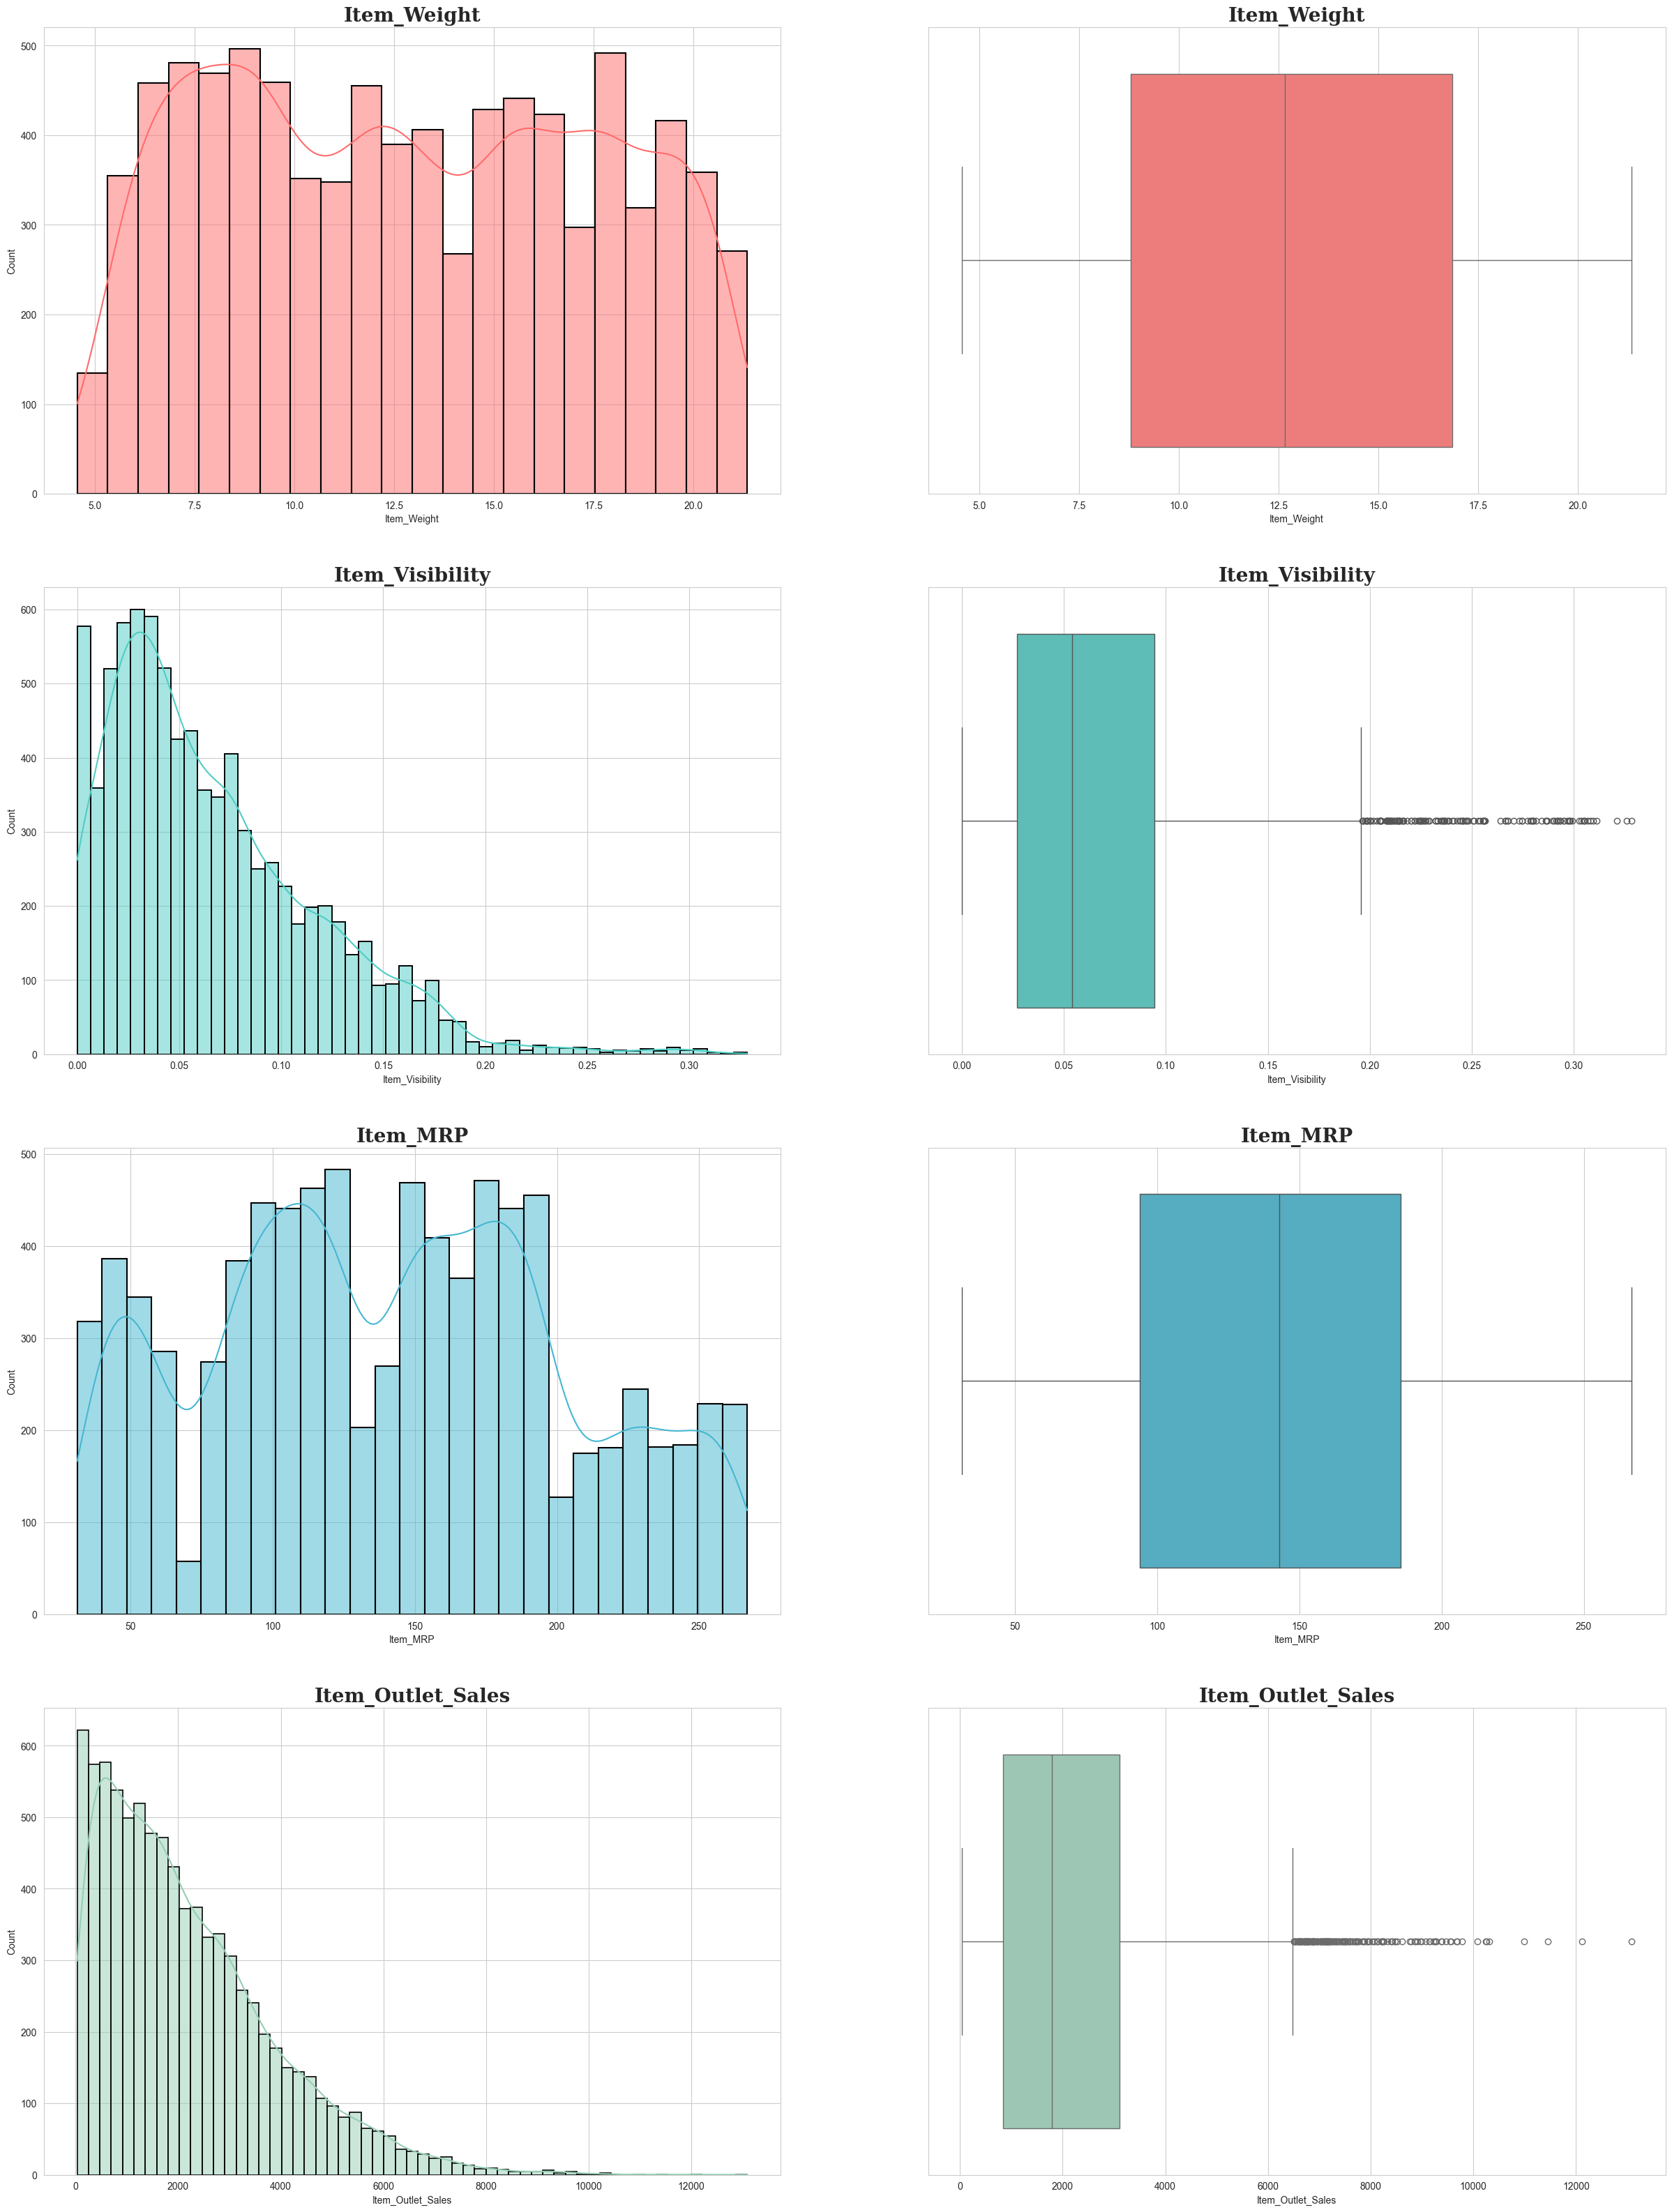

In [80]:
num_columns = ['Item_Weight','Item_Visibility','Item_MRP','Item_Outlet_Sales']
kdeplot_and_boxplot(df,num_columns)

## Category Columns

In [81]:
def pie_plot(columns,df):
    num_columns = 2
    num_rows = 3

    fig,axes = plt.subplots(num_rows,num_columns,figsize=(14,12))
    axes = axes.flatten()
    for i,column in enumerate(columns):
        counts = df[column].value_counts()
        colors = palette[:df[column].nunique()]

        axes[i].pie(counts.values,labels=counts.index,autopct='%.2f%%',colors=palette)
        axes[i].set_title(f'{column} Distribution',fontsize=20,fontweight='bold')

    for j in range(len(columns), len(axes)):
        axes[j].axis('off')

    plt.tight_layout()
    plt.show()

In [82]:
df_cp =  df.copy()
item_counts = df_cp['Item_Type'].value_counts()

def categorize_item_type(item_type):
    if item_counts[item_type] < 445:
        return 'Others'
    return item_type

df_cp['Item_Type'] = df_cp['Item_Type'].apply(categorize_item_type)
df_cp['Item_Type'].value_counts()

Item_Type
Others                   1381
Fruits and Vegetables    1232
Snack Foods              1199
Household                 910
Frozen Foods              855
Dairy                     681
Canned                    649
Baking Goods              647
Health and Hygiene        520
Soft Drinks               445
Name: count, dtype: int64

## **Bivariate Analysis**

## Item MRP (Maximum Retail Price) vs. Sales

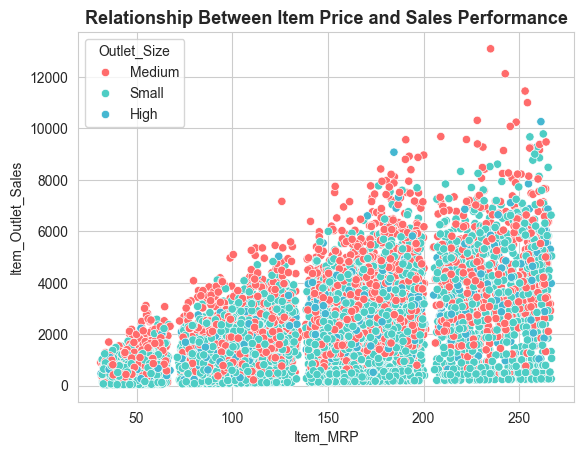

In [83]:
sns.scatterplot(x='Item_MRP',y='Item_Outlet_Sales',hue='Outlet_Size',data=df, palette=palette[:3])

plt.title('Relationship Between Item Price and Sales Performance',fontsize=13,fontweight='bold')
plt.show()

## Outlet Type vs. Sales

In [84]:
type_sales = df.groupby('Outlet_Type')['Item_Outlet_Sales'].mean().sort_values(ascending=False).reset_index()
type_sales

,Outlet_Type,Item_Outlet_Sales
0,Supermarket Type3,3695.781505
1,Supermarket Type1,2316.181148
2,Supermarket Type2,1995.498739
3,Grocery Store,340.031198


## Outlet Location vs. Sales

In [86]:
location_sales = df.groupby('Outlet_Location_Type')['Item_Outlet_Sales'].mean().reset_index().sort_values(by='Outlet_Location_Type')
location_sales

,Outlet_Location_Type,Item_Outlet_Sales
0,Tier 1,1877.644978
1,Tier 2,2323.990559
2,Tier 3,2278.845218


## Outlet Size vs. Sales

In [88]:
size_sales = df.groupby('Outlet_Size')['Item_Outlet_Sales'].mean().reset_index()
size_sales

,Outlet_Size,Item_Outlet_Sales
0,High,2298.995256
1,Medium,2681.097134
2,Small,1867.546932


Text(0.5, 1.0, 'Outlet_Size')

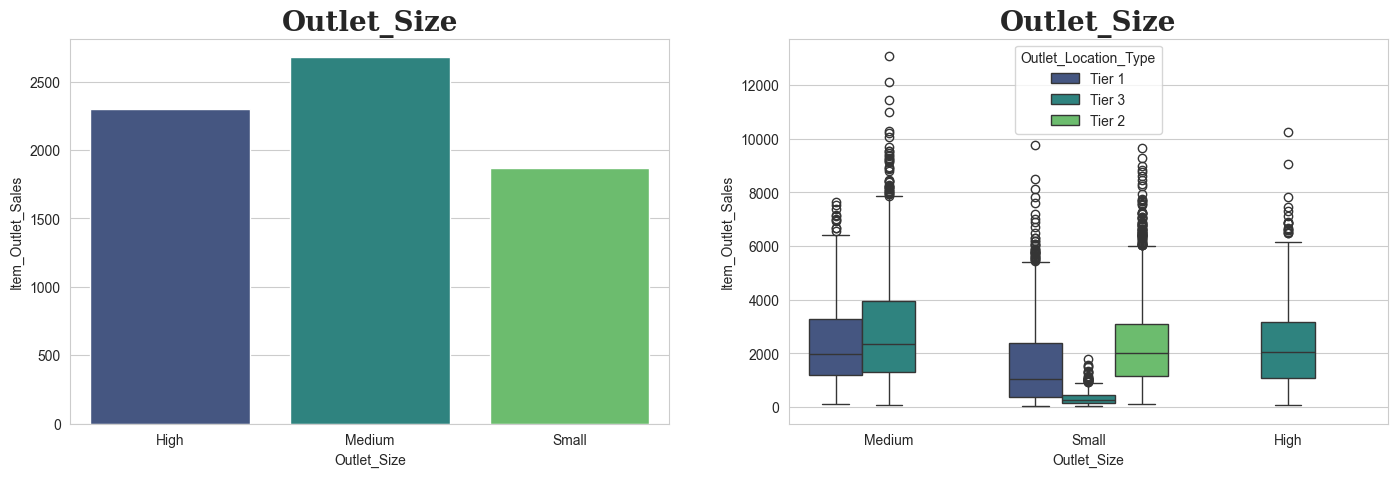

In [89]:
fig, ax = plt.subplots(1, 2, figsize = (17, 5))

sns.barplot(x='Outlet_Size',y='Item_Outlet_Sales',data=size_sales,ax=ax[0],palette='viridis')
ax[0].set_title('Outlet_Size', fontweight = 'bold', fontfamily='serif', fontsize=20)
sns.boxplot(x='Outlet_Size',y='Item_Outlet_Sales',hue='Outlet_Location_Type',data=df,ax=ax[1],palette='viridis')
ax[1].set_title('Outlet_Size', fontweight = 'bold', fontfamily='serif', fontsize=20)

## Item Fat Content vs. Sales

In [90]:
fat_sales = df.groupby('Item_Fat_Content')['Item_Outlet_Sales'].mean().reset_index()
fat_sales

,Item_Fat_Content,Item_Outlet_Sales
0,Low Fat,2157.298823
1,Regular,2225.070565


## Item Type vs. Sales

In [92]:
item_type = df.groupby('Item_Type')['Item_Outlet_Sales'].mean().sort_values(ascending=False).reset_index()
item_type

,Item_Type,Item_Outlet_Sales
0,Starchy Foods,2374.332773
1,Seafood,2326.065928
2,Fruits and Vegetables,2289.009592
3,Snack Foods,2275.522818
4,Household,2258.784300
5,Dairy,2230.749701
6,Canned,2225.194904
7,Breads,2204.132226
8,Meat,2158.977911
9,Hard Drinks,2139.221622


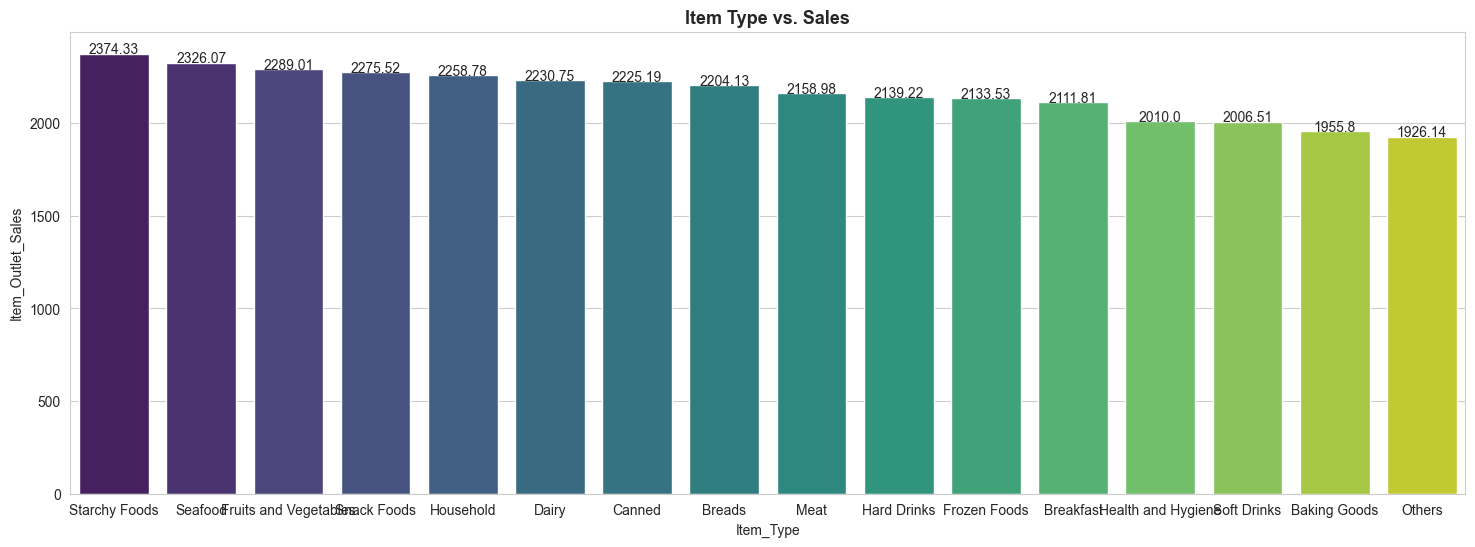

In [93]:
plt.figure(figsize=(18,6))

sns.barplot(x='Item_Type',y='Item_Outlet_Sales',data=item_type,palette='viridis')
plt.title('Item Type vs. Sales',fontsize=13,fontweight='bold')

for index, value in enumerate(item_type['Item_Outlet_Sales']):
    plt.text(index, value + 0.02, round(value, 2), ha="center")

plt.show()

## Outlet Establishment Year vs. Sales

In [94]:
year_sales = df.groupby('Outlet_Establishment_Year')['Item_Outlet_Sales'].mean().sort_values(ascending=False).reset_index()
year_sales

,Outlet_Establishment_Year,Item_Outlet_Sales
0,1985,2483.921827
1,2004,2438.841866
2,1999,2348.354635
3,2007,2340.675263
4,1987,2298.995256
5,1997,2277.844267
6,2002,2192.384798
7,2009,1995.498739
8,1998,339.351662


Text(0.5, 1.0, 'Outlet Establishment Year vs. Sales')

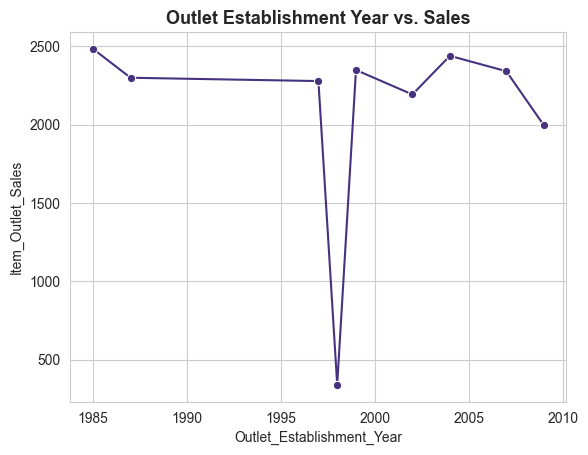

In [95]:
sns.lineplot(x='Outlet_Establishment_Year',y='Item_Outlet_Sales',data=year_sales,marker='o')
plt.title('Outlet Establishment Year vs. Sales',fontsize=13,fontweight='bold')

## Correlation

<Axes: >

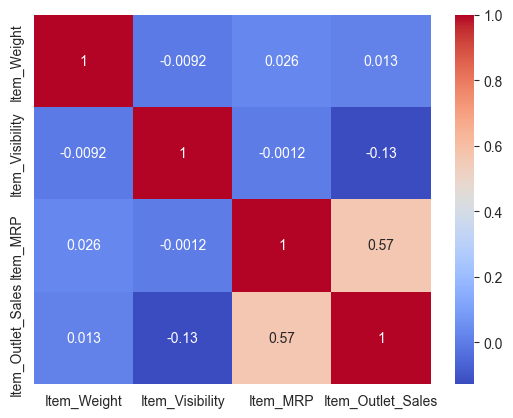

In [96]:
sns.heatmap(df[num_columns].corr(),cmap='coolwarm',annot=True)

# **Modeling**

<Axes: >

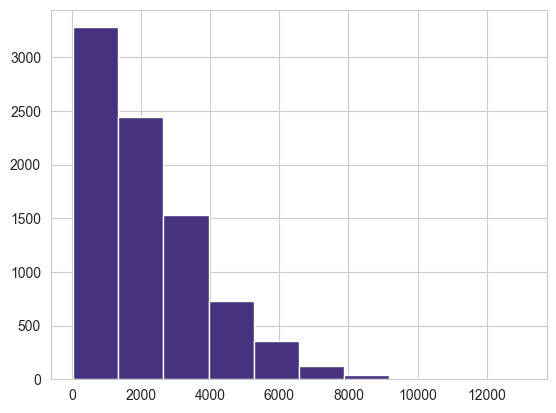

In [97]:
df['Item_Outlet_Sales'].hist()

## **Log Transform Sales**

To reduce the skewness in the `Item_Outlet_Sales` column, we apply a logarithmic transformation

<Axes: >

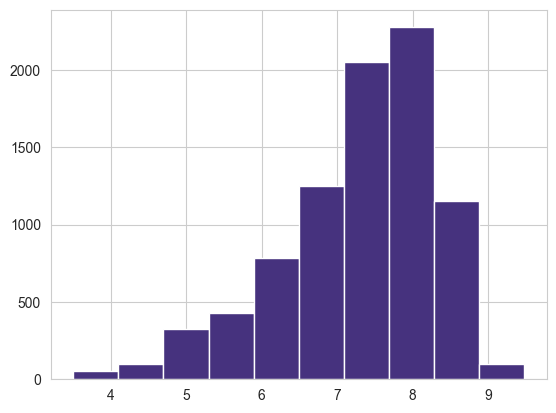

In [98]:
np.log(df['Item_Outlet_Sales']).hist()

In [99]:
num_columns = ['Item_Weight','Item_Visibility','Item_MRP','Outlet_Establishment_Year']

nominal_columns = ['Item_Type','Outlet_Location_Type','Outlet_Type','Outlet_Identifier']
ordinal_columns = ['Item_Fat_Content','Outlet_Size']

## **Perpare PipeLine**

In [100]:
num_pipeline = Pipeline([
    ('poly', PolynomialFeatures()),
    ('scaler',StandardScaler())
    ])

ordinal_pipeline = Pipeline([
    ('ord_encoder',OrdinalEncoder())
])

nominal_pipeline = Pipeline([
    ('nom_encoder',OneHotEncoder(drop='first',sparse_output = False))
])

preprocessor = ColumnTransformer([
    ('num_pipeline',num_pipeline,num_columns),
    ('ordinal_pipeline',ordinal_pipeline,ordinal_columns),
    ('nominal_pipeline',nominal_pipeline,nominal_columns)
]).set_output(transform = 'pandas')

In [101]:
# One Split for Validation
X = df.drop(['Item_Outlet_Sales','Item_Identifier'], axis = 1)
y = np.log(df['Item_Outlet_Sales'])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size = 0.2, random_state = 42)

print('X_train shape -- ', X_train.shape)
print('y_train shape -- ', y_train.shape)
print('X_Validtrain shape -- ', X_valid.shape)
print('y_Valid shape -- ', y_valid.shape)
print('X_test shape -- ', X_test.shape)
print('y_test shape -- ', y_test.shape)

X_train shape --  (5452, 10)
y_train shape --  (5452,)
X_Validtrain shape --  (1363, 10)
y_Valid shape --  (1363,)
X_test shape --  (1704, 10)
y_test shape --  (1704,)


## **Fine Tuning**

In [102]:
models = [
    Pipeline([('preprocessor', preprocessor), ('XGBRegressor', XGBRegressor(tree_method='gpu_hist'))])
]

params = [
    # Parameters for XGBoost with GPU
    {'preprocessor__num_pipeline__poly__degree': [2, 3, 4, 5],
     'XGBRegressor__n_estimators': [50, 100],
     'XGBRegressor__learning_rate': [0.01, 0.1, 0.2],
     'XGBRegressor__max_depth': [3, 4, 5],
     'XGBRegressor__gamma': [0, 0.1, 0.2]}
]

grid_search = []
results = []
model_names = ['XGBoost_GPU']

for model, param_grid, model_name in zip(models, params, model_names):
    grid = GridSearchCV(model, param_grid, cv=5, scoring='r2', n_jobs=-1)
    grid.fit(X_train, y_train)
    grid_search.append(grid)


    print(f'{model_name} - Best Params: {grid.best_params_}')
    print(f'{model_name} - Best R² Score: {grid.best_score_:.4f}')

    best_model = grid.best_estimator_
    y_valid_pred = best_model.predict(X_valid)

    mae = mean_absolute_error(y_valid, y_valid_pred)
    mse = mean_squared_error(y_valid, y_valid_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_valid, y_valid_pred)


    results.append({
        'Model': model_name,
        'Best Params': grid.best_params_,
        'MAE': mae,
        'MSE': mse,
        'RMSE': rmse,
        'R²': r2
    })

    model_filename = f"{model_name}_best_model.pkl"
    pickle.dump(best_model, open(model_filename, 'wb'))
    print(f"Model {model_name} saved as {model_filename}")

    print(f'{model_name} - MAE: {mae:.5f}')
    print(f'{model_name} - MSE: {mse:.5f}')
    print(f'{model_name} - RMSE: {rmse:.5f}')
    print(f'{model_name} - R²: {r2:.5f}')
    print('----------------------------------------------------------------------------------------------------------------')

df_vald_results = pd.DataFrame(results)

XGBoost_GPU - Best Params: {'XGBRegressor__gamma': 0, 'XGBRegressor__learning_rate': 0.1, 'XGBRegressor__max_depth': 3, 'XGBRegressor__n_estimators': 100, 'preprocessor__num_pipeline__poly__degree': 2}
XGBoost_GPU - Best R² Score: 0.7362
Model XGBoost_GPU saved as XGBoost_GPU_best_model.pkl
XGBoost_GPU - MAE: 0.42014
XGBoost_GPU - MSE: 0.29723
XGBoost_GPU - RMSE: 0.54519
XGBoost_GPU - R²: 0.71486
----------------------------------------------------------------------------------------------------------------


In [103]:
df_vald_results.sort_values(by='R²',ascending=False)

,Model,Best Params,MAE,MSE,RMSE,R²
0,XGBoost_GPU,"{'XGBRegressor__gamma': 0, 'XGBRegressor__lear...",0.420136,0.297228,0.545186,0.714856


## **Test Model**

In [110]:
results = []
current_model = 0

# Load and evaluate only the XGBoost GPU model
model_path = "XGBoost_GPU_best_model.pkl"
try:
    # Load the model
    model = pickle.load(open(model_path, "rb"))
    
    X_test_pred = model.predict(X_test)
    
    mae = mean_absolute_error(y_test, X_test_pred)
    mse = mean_squared_error(y_test, X_test_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, X_test_pred)
    
    result = {
        'Model': 'XGBoost_GPU',
        'MAE': mae,
        'MSE': mse,
        'RMSE': rmse,
        'R²': r2
    }
    
    if hasattr(model, 'best_params_'):
        result['Best Params'] = model.best_params_
    
    results.append(result)
    
    print(f"XGBoost GPU Model Evaluation:")
    print(f"MAE: {mae:.4f}")
    print(f"MSE: {mse:.4f}")
    print(f"RMSE: {rmse:.4f}")
    print(f"R²: {r2:.4f}")
    if 'Best Params' in result:
        print(f"Best Parameters: {result['Best Params']}")
        
except Exception as e:
    print(f"Error processing XGBoost GPU model: {e}")

df_results = pd.DataFrame(results)

XGBoost GPU Model Evaluation:
MAE: 0.3986
MSE: 0.2628
RMSE: 0.5127
R²: 0.7435


In [111]:
df_results.sort_values(by='R²',ascending=False)

,Model,MAE,MSE,RMSE,R²
0,XGBoost_GPU,0.398626,0.262818,0.512658,0.74348


# **Results**

## XGBoost GPU Model Performance
The performance metrics of the GPU-accelerated XGBoost model are shown above. This model leverages GPU acceleration through the 'gpu_hist' tree method for faster training while maintaining the same level of accuracy.